In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from keras import layers
from utils import *
from sklearn.linear_model import LogisticRegression as LogRes
from sklearn.metrics import classification_report as report
from sklearn.metrics import precision_score as precision 
from sklearn.metrics import recall_score as recall

In [2]:
x_train, y_train = load_data("../data/Simulated_Data_Train.csv")
x_val, y_val = load_data("../data/Simulated_Data_Validation.csv")
x_test, y_test = load_data("../data/Simulated_Data_Test.csv")

array([[6.3651270e+04, 9.0199900e+03, 4.8400000e+02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0555929e+05, 1.6692190e+04, 2.1200000e+02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.6062990e+04, 1.0509130e+04, 2.5500000e+02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [7.4738730e+04, 1.2175490e+04, 3.5100000e+02, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [1.2035758e+05, 1.4477700e+04, 3.0800000e+02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.4240170e+04, 1.1873450e+04, 3.4100000e+02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [3]:
class log_reg(): 
    
    def __init__(self, data, response): 
        """
        Initialized and trains the logistic regression model with 
        the given data and resposne. 
        
        Keyword Arguments: 
        data - the input matrix 
        reponse - the output vector
        """
        self.x = data 
        self.y = response 
        #Set Seed for Reproducibility
        self.model = LogRes(random_state = 462021).fit(self.x, self.y)
        
    def predict(self, x): 
        """
        Returns predicted probabilities NOT Classes for 
        the model. Tuning may be needed for optimal results for the 
        decision rule. 
        
        Keyword Arguments: 
        x - the data to generate predictions on 
        """
        return self.model.predict_proba(x)[:,1]

In [9]:
from sklearn.metrics import precision_score, recall_score

def precision(y, yhat): 
    """
    The precision of the model in regards to correctly 
    predicting if a consumer will default. (Precision for 1.0)
    
    Keyword Arguments: 
    y - the true values 
    yhat - the predicted values
    """
    return(precision_score(y, yhat))

In [10]:
lr = log_reg(x_train, y_train)
yprob = lr.predict(x_train)
threshold = tune_threshold(y_train, yprob)
print(threshold)
yhat = decide(yprob, threshold)
print(report(y_train, lr.model.predict(x_train)))
print(report(y_train, decide(yprob, threshold)))

print(precision(y_train, yhat))

Accuracy = 0.9306, Threshold = 0.5, Loss = 0.058
Accuracy = 0.9305, Threshold = 0.5058, Loss = 0.058
0.5
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     18414
         1.0       0.73      0.20      0.31      1586

    accuracy                           0.93     20000
   macro avg       0.83      0.60      0.64     20000
weighted avg       0.92      0.93      0.91     20000

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     18414
         1.0       0.73      0.20      0.31      1586

    accuracy                           0.93     20000
   macro avg       0.83      0.60      0.64     20000
weighted avg       0.92      0.93      0.91     20000

0.7323943661971831


In [11]:
class feed_forward(): 
    
    def __init__(self, data, response): 
        """
        Initializes a feed_forward nueral network for this 
        specfic problem of credit classification. 
        
        Keyword Arguments: 
        
        data - the input matrix 
        response - the output response vector
        """
        self.x = data 
        self.y = response 
        self.model = feed_forward.build_model(self.x, self.y)
        
        
    def build_model(x, y, suppress = False, width = 20): 
        """
        Builds a feed forward nueral network with a hidden layer 
        of 20 nuerons. 
        
        Keyword Arguments: 
        
        x - the input data being used to build to model
        y - the response vector model is going to be trained on 
        suppress - if true will not print out model summary
        width - the size of the hidden layer
        """
        model = keras.Sequential()
        model.add(layers.Dense(width, input_dim = x.shape[1], 
                            kernel_initializer = "uniform", 
                            activation = "relu", ))
        model.add(layers.Dense(1, kernel_initializer = "normal", activation = "sigmoid"))
        model.compile(loss = "binary_crossentropy", optimizer = "adam")
        if not suppress: 
            model.summary()
        return model


    def train(self, epochs = 20): 
        """
        Trains the model for a certain number of epochs. Default 
        is 20. 
        """
        self.model.fit(self.x, self.y, epochs = epochs, verbose = 1)
        
        
    def predict(self, x): 
        """
        Generates Predictions of 0 or 1. 
        """
        y_prob = self.model.predict(x)[:,0]
        yhat = decide(y_prob, 0.5)
        
        return yhat

In [12]:
nn = feed_forward(x_train, y_train)
nn.train(20)
nn.predict(x_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
625/625 [==============================] - 1s 919us/step - loss: 3.9164
Epoch 2/20
625/625 [==============================] - 0s 684us/step - loss: 2.6951
Epoch 3/20
625/625 [==============================] - 0s 658us/step - loss: 1.5024
Epoch 4/20
625/625 [==============================] - 0s 791us/step - loss: 1.0691
Epoch 5/20
625/625 [==============================] - 1s 809us/step - loss: 0.9888
Epoch 6/20
625/625 [==============================] - 0s 634us/step - loss: 0.4950
Epoch 7/20
625/625 [==

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
yhat = nn.predict(x_train)
print(report(y_train, yhat))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18414
         1.0       0.73      0.13      0.21      1586

    accuracy                           0.93     20000
   macro avg       0.83      0.56      0.59     20000
weighted avg       0.91      0.93      0.90     20000



In [177]:
y_prob = model.predict(x_train)[:,0]
yhat = decide(y_prob, 0.5)

accuracy(y_train, yhat)


0.9207

In [178]:
y_val_prob = model.predict(x_val)[:,0]
y_val_hat = decide(y_val_prob, 0.5)

tune_threshold(y_val, y_val_prob)

Accuracy = 0.926, Threshold = 0.5, Loss = 0.074
Accuracy = 0.926, Threshold = 0.5074, Loss = 0.074


0.5

In [120]:
def tune_model_width(build_fn, x_train, y_train, x_val, y_val, max_width = 50): 
    width = 20
    model = feed_forward.build_model(x_train, y_train, width = width, suppress = True)
    model.fit(x_train, y_train, epochs = 25, verbose = 0)
    
    y_val_prob = model.predict(x_val)[:,0]
    y_val_hat = decide(y_val_prob, 0.5)
    
    validation_accuracy = accuracy(y_val, y_val_hat)
    
    y_train_prob = model.predict(x_train)[:,0]
    y_train_hat = decide(y_train_prob, 0.5)
    
    training_accuracy = accuracy(y_train, y_train_hat)
    
    distance = training_accuracy - validation_accuracy
    
    print(f"Width: {width}, Training_Accuracy = {training_accuracy}, Validation Accuracy = {validation_accuracy}")
    
    for i in range(21, max_width): 
        width = i
        
        model = build_fn(x_train, y_train, width = width, suppress = True)
        model.fit(x_train, y_train, epochs = 25, verbose = 0)

        y_val_prob = model.predict(x_val)[:,0]
        y_val_hat = decide(y_val_prob, 0.5)

        validation_accuracy = accuracy(y_val, y_val_hat)

        y_train_prob = model.predict(x_val)[:,0]
        y_train_hat = decide(y_train_hat, 0.5)

        training_accuracy = accuracy(y_train, y_train_hat)

        print(f"Width: {width}, Training_Accuracy = {training_accuracy}, Validation Accuracy = {validation_accuracy}")
    

tune_model_width(build_fn, x_train, y_train, x_val, y_val)

    
    

Width: 20, Training_Accuracy = 0.9322, Validation Accuracy = 0.9356666666666666
Width: 20, Training_Accuracy = 0.9322, Validation Accuracy = 0.926
Width: 21, Training_Accuracy = 0.9322, Validation Accuracy = 0.926
Width: 22, Training_Accuracy = 0.9322, Validation Accuracy = 0.926
Width: 23, Training_Accuracy = 0.9322, Validation Accuracy = 0.926
Width: 24, Training_Accuracy = 0.9322, Validation Accuracy = 0.926
Width: 25, Training_Accuracy = 0.9322, Validation Accuracy = 0.9266666666666666
Width: 26, Training_Accuracy = 0.9322, Validation Accuracy = 0.9263333333333333
Width: 27, Training_Accuracy = 0.9322, Validation Accuracy = 0.926
Width: 28, Training_Accuracy = 0.9322, Validation Accuracy = 0.9323333333333333
Width: 29, Training_Accuracy = 0.9322, Validation Accuracy = 0.926
Width: 30, Training_Accuracy = 0.9322, Validation Accuracy = 0.9326666666666666
Width: 31, Training_Accuracy = 0.9322, Validation Accuracy = 0.9303333333333333
Width: 32, Training_Accuracy = 0.9322, Validation A

In [12]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [13]:
random_forest = RFC().fit(x_train, y_train)
y_prob = random_forest.predict(x_train)


In [15]:
print(report(y_val, random_forest.predict(x_val)))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      2778
         1.0       0.81      0.27      0.41       222

    accuracy                           0.94      3000
   macro avg       0.88      0.63      0.69      3000
weighted avg       0.94      0.94      0.93      3000



In [143]:
credit_data = pd.read_csv("../data/Simulated_Data_Train.csv")

In [148]:
incorrect = ((y_train - yhat)**2 == 1)

In [163]:
credit_data.mean() - credit_data.iloc[incorrect].mean()

tot_credit_debt                       3095.096550
avg_card_debt                        -3726.806435
credit_age                              19.173510
credit_good_age                          8.828424
card_age                                18.110651
non_mtg_acc_past_due_12_months_num      -0.291335
non_mtg_acc_past_due_6_months_num       -0.079983
mortgages_past_due_6_months_num         -0.109248
credit_past_due_amount               -1012.201835
inq_12_month_num                        -0.404340
card_inq_24_month_num                   -0.557589
card_open_36_month_num                  -0.020395
auto_open_ 36_month_num                 -0.002922
uti_card                                -0.057655
uti_50plus_pct                          -0.047760
uti_max_credit_line                     -0.042977
uti_card_50plus_pct                     -0.056593
ind_acc_XYZ                              0.045276
rep_income                             281.448200
Default_ind                             -0.820775


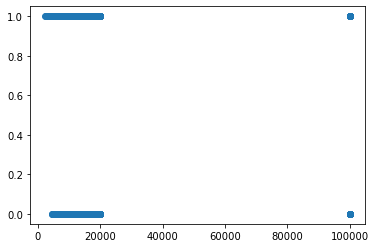